# PREDATOR: **PRED**icting the imp**A**ct of cancer somatic mu**T**ations on pr**O**tein-protein inte**R**actions



<b><i class="fa fa-folder-o" area-hidden="true" style="color:#1976D2"> </i>&nbsp; File Location</b><br>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">C:\Users\ibrah\Documents\GitHub\Predicting-Mutation-Effects\src</code>
</p>

<b><i class="far fa-file" area-hidden="true" style="color:#1976D2"> </i>&nbsp; File Name</b>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">PredatorStudy.ipynb</code>
</p>

<b><i class="far fa-calendar-alt" area-hidden="true" style="color:#1976D2"> </i>&nbsp; Last Edited</b>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">September 6th, 2021</code>
</p>


<div class="alert alert-block" style="background-color: #F5F5F5; border: 1px solid; padding: 10px; border-color: #E0E0E0">
    <b><i class="fa fa-compass" aria-hidden="true" style="color:#404040"></i></b>&nbsp; <b style="color: #404040">Purpose </b> <br>
<div>

    
- [x] $\textit{mutation effect label}$ prediction using Random Forest algorithm.
    

- [x] Classification will be $\textit{Disrupting vs (No effect + Increasing)}$.
    > $\textit{Disrupting} → 0$\
    > $\textit{No effect + Increasing} → 1$\
    > $\textit{Decreasing} → \textit{ignored}$
    
    
- [x] Evaluate the performane of the model.
    
- [x] We use SHAP in feature selection
    
    
- [x] Apply on Cancer Datasets
    > For now, a portion of all BRCA. But will be updated.
     
- [x] We measure the impact of randomization by repeating whole experiment with multiple runs. 
    
- [x] We use Predator object to conduct experiments.
    
**Dependent files:**
* Training (mutations) data:
    - *training_data_M1.txt*


* Target (Cancer) data: 
    - *BRCA_INTERFACE_A2.txt*

In [1]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import random
from IPython.display import display
from tqdm.notebook import tqdm
from helpers.helpers_predator.displayers import display_label_counts, display_labels, visualize_label_counts
from helpers.helpers_predator.visualizers import (
    visualize_sampled_train_datasets_label_counts
)

NUM_EXPERIMENT_REPEAT = 50

SEED = 42
random.seed(SEED)
random_seeds = random.sample(range(1, 99999), NUM_EXPERIMENT_REPEAT)

# PATHS
PROJECT_COMMON_FILE_DIR = "../data/"
MUTATIONS_PATH = "training_data_M1.txt"
INITIAL_COLUMNS_PATH = "../data/initial_columns_59.csv"
BRCA_PATH = "../data/BRCA_INTERFACE_A2.txt"

# Reflect changes in the modules immediately.
%load_ext autoreload
%autoreload 2

In [2]:
from Predator import Predator

In [3]:
predator = Predator(project_common_file_dir=PROJECT_COMMON_FILE_DIR, 
                    mutations_path=MUTATIONS_PATH, 
                    tcga_code_path_pairs=[('brca', BRCA_PATH)],
                    initial_columns_path=INITIAL_COLUMNS_PATH, 
                    n_experiment=50)

2021-09-07 16:48:40 | DEBUG    | Predator | Initializing Predator ..
2021-09-07 16:48:40 | DEBUG    | helpers.helpers_predator.data_materials | Initialize `train_data` ..
2021-09-07 16:48:40 | DEBUG    | helpers.helpers_predator.data_materials | Initialize `train_data_processed` ..
2021-09-07 16:48:40 | DEBUG    | helpers.helpers_predator.data_materials | Initialize `brca` ..
2021-09-07 16:48:40 | DEBUG    | helpers.helpers_predator.data_materials | Initialize `target_brca_data` ..


## Datasets

### Original Datasets

#### 1. Training Data: Mutations

In [4]:
predator.data_materials["train_data"].head(3)

,Mutation_Effect_Label,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
1,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
2,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627


#### 2. TCGA Cancer Datasets

##### BRCA

In [5]:
predator.data_materials["brca"].head(3)

,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,Domain_clan,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224


### Processed Datasets

#### 1. Preprocessed Training Data 

In [6]:
predator.data_materials["train_data_processed"].head(3)

,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.21970,-0.092273,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.07695,0.998749,...,329.0,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123
2,0,Q96QK1,F534D,Q9UBQ0,1.0000,0.360743,1.0000,0.994505,2.69571,0.288297,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435


2021-09-07 16:48:41 | DEBUG    | helpers.helpers_predator.displayers | Label counts:
Disrupting                540
Increasing + No Effect    200
Name: Mutation_Effect_Label, dtype: int64


,Mutation_Effect_Label,Counts
Disrupting,0,540
Increasing + No Effect,1,200


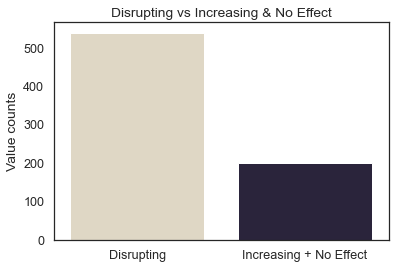

In [7]:
visualize_label_counts(predator.data_materials["train_data_processed"])
display_label_counts(predator.data_materials["train_data_processed"])

#### 2. Preprocessed TCGA Cancer Datasets

##### BRCA

In [8]:
predator.data_materials["target_brca_data"].head(3)

,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,Q9UKS6,R24H,Q9BY11,0.5343,0.530760,0.9857,0.936088,0.730056,0.957610,0.741488,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,Q9UKS6,R24H,Q9UNF0,0.5884,0.579682,0.9928,0.993160,0.795178,0.927519,0.019506,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,Q9UKS6,R24H,Q9UNF0-2,0.5884,0.579682,0.9928,0.993160,1.030540,0.927519,0.014609,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.300,2331.75,3.55240,4.79224


## Data Sampling with Unique Proteins

In [9]:
predator.sample_spsm()

2021-09-07 16:48:42 | DEBUG    | Predator | sampling ..


  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'brca', 'target_brca_data', 'sampled_train_data_list'])

In [11]:
predator.data_materials["sampled_train_data_list"][0].head()

,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.076950,0.998749,...,329.0,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123
2,0,Q96QK1,T629D,Q9UBQ0-2,1.0000,0.360743,1.0000,0.973118,1.252190,0.403159,...,453.0,68.34290,68.21480,59.2629,59.2629,510.690,298.820,809.510,4.36339,4.34314
3,0,O43521-3,G66E,P10415-2,1.0000,0.714286,0.6505,0.435452,1.866070,-0.076393,...,181.0,2.15789,3.50531,30.7415,30.7626,421.875,272.215,694.090,3.41921,1.76365
4,1,Q13418,Q362H,Q9NVD7,0.9925,0.971054,1.0000,0.961240,0.621791,0.206189,...,391.0,60.07690,60.06430,33.8017,33.8017,406.135,174.195,580.330,3.39874,3.39874


In [12]:
# Number of sampled train data
len(predator.data_materials["sampled_train_data_list"])

50

### Label Distributions in Training Data

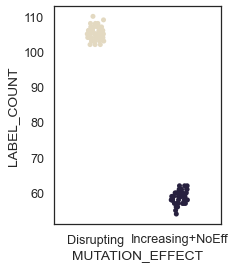

In [13]:
visualize_sampled_train_datasets_label_counts(predator.data_materials["sampled_train_data_list"], kind='strip')

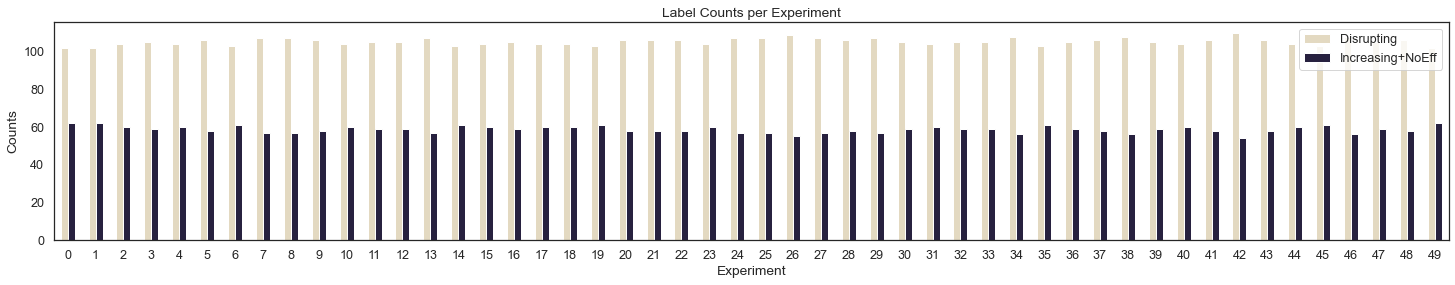

In [14]:
visualize_sampled_train_datasets_label_counts(predator.data_materials["sampled_train_data_list"], kind='bar')

## Preparing the Train Data Materials for Machine Learning Algorithms

In [15]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'brca', 'target_brca_data', 'sampled_train_data_list'])

In [16]:
predator.data_materials.prepare_model_data_materials()  # it will initialize Xs etc. too

2021-09-07 16:49:01 | DEBUG    | helpers.helpers_predator.data_materials | preparing datasets for ML ..
2021-09-07 16:49:01 | DEBUG    | helpers.helpers_predator.data_materials | Initializing model datasets ..


  0%|          | 0/50 [00:00<?, ?it/s]

2021-09-07 16:49:01 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-09-07 16:49:01 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-09-07 16:49:01 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-09-07 16:49:01 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-09-07 16:49:01 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-09-07 16:49:01 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-09-07 16:49:01 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-09-07 16:49:01 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-09-07 16:49:01 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-09-07 16:49:01 | DEBUG    | helpers.helpers_predator.data_materials 

In [17]:
print(len(predator.data_materials["Xs"]))
predator.data_materials["Xs"][0].head()

50


,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,1.0000,0.483871,0.9930,0.863124,5.977720,-0.103788,0.841449,1.551375,-0.805142,-8.790,...,316.0,8.64833,8.63232,90.3947,89.1921,524.985,258.980,783.96,2.46202,2.98422
1,1.0000,1.000000,0.4167,0.372027,1.700660,-0.116186,0.028181,-0.446740,0.127684,-7.998,...,249.0,27.72640,27.86500,139.5970,139.5970,386.025,245.065,631.09,3.57046,3.48332
2,0.6803,0.517968,0.4645,0.481888,0.937272,0.058100,0.165439,-0.028320,1.569780,-3.628,...,318.0,293.43500,294.70400,45.8003,45.8003,716.790,358.840,1075.62,4.33509,4.33509
3,0.9945,0.975130,0.9939,0.906319,1.511710,0.994536,0.171553,1.875893,-0.410594,-6.333,...,712.0,200.85600,199.44300,62.1484,62.1484,267.500,155.585,423.08,3.07379,3.07379
4,0.9032,0.902219,0.8519,0.838599,1.414480,0.156140,0.500075,1.100519,0.299283,-5.300,...,236.0,49.67150,48.43100,23.9715,23.9715,176.945,115.630,292.58,2.94553,5.48003


## Initial Insights

For each experiment, the models are fitted with 80% of training data and predictions are made for the remaining 20%. Then performance is evaluated comparing predictions with groundtruth labels.

In [18]:
predator.run_evaluate_valid(models_type='default')

2021-09-07 16:49:02 | DEBUG    | helpers.helpers_predator.evaluation | Training on train set and measuring performance by predicting on validation set.
2021-09-07 16:49:02 | DEBUG    | helpers.helpers_predator.evaluation | Evaluating with default models.


  0%|          | 0/50 [00:00<?, ?it/s]

-------- EXPERIMENT:  1 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Accuracy score		: 0.6667
Balanced accuracy score : 0.5952
-------- EXPERIMENT:  2 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Accuracy score		: 0.6970
Balanced accuracy score : 0.6190
-------- EXPERIMENT:  3 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Accuracy score		: 0.6970
Balanced accuracy score : 0.6548
-------- EXPERIMENT:  4 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Accuracy score		: 0.6970
Balanced accuracy score : 0.6012
-------- EXPERIMENT:  5 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Accuracy score		: 0.7273
Balanced accuracy score : 0.6429
-------- EXPERIMENT:  6 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.sh

In [19]:
from helpers.helpers_predator.visualizers import visualize_accuracy_metrics

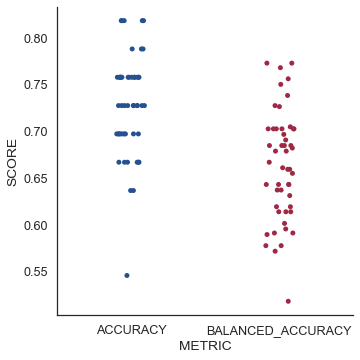

In [20]:
visualize_accuracy_metrics(
    predator.eval_valid.scores["initial_scoring"]["acc_scores"], 
    predator.eval_valid.scores["initial_scoring"]["balan_acc_scores"],
    kind='strip'
)

## SHAP Feature Importance Ranking

In [21]:
# shap_top_ns = [10, 20]
shap_top_ns = [5, 10, 20, 30, 40]

In [22]:
predator.init_shap_feature_selector(shap_top_ns)

2021-09-07 16:49:17 | DEBUG    | helpers.helpers_predator.feature_selection | Initializing ShapFeatureSelector ..


2021-09-07 16:49:17 | DEBUG    | helpers.helpers_predator.feature_selection | Loading ShapFeatureSelector ..


  0%|          | 0/50 [00:00<?, ?it/s]

 === SELECTED FEATURES === 
 --- SHAP TOP 5 ---
Experiment 1
['Provean_score', 'EL2_score', 'Matrix_score', 'electrostatics_mut', 'Final_ddG']

Experiment 2
['Provean_score', 'EL2_score', 'Final_ddG', 'solvation_polar_wt', 'entropy_mainchain_wt']

Experiment 3
['EL2_score', 'Final_ddG', 'Provean_score', 'Interface_contact_distance_mut', 'Interface_contact_distance_wt']

Experiment 4
['EL2_score', 'Provean_score', 'Final_ddG', 'Interface_contact_distance_mut', 'entropy_sidechain_mut']

Experiment 5
['EL2_score', 'Provean_score', 'Final_ddG', 'sidechain_hbond_mut', 'Solvent_accessibility_wt']

Experiment 6
['Final_ddG', 'EL2_score', 'Provean_score', 'solvation_polar_mut', 'solvation_polar_wt']

Experiment 7
['EL2_score', 'Provean_score', 'Final_ddG', 'Matrix_score', 'electrostatics_mut']

Experiment 8
['EL2_score', 'Provean_score', 'Final_ddG', 'Solvent_accessibility_mut', 'pcv_vdW_self_wt']

Experiment 9
['Provean_score', 'EL2_score', 'Final_ddG', 'Matrix_score', 'ProteinSolver_score']


## Aggregated Feature Selection

In [23]:
predator.aggregate_selected_features('occurrence')

2021-09-07 16:49:35 | DEBUG    | helpers.helpers_predator.data_materials | Initialize feature selected data materials [n_top=5]..
2021-09-07 16:49:35 | DEBUG    | helpers.helpers_predator.data_materials | Initialize feature selected data materials [n_top=10]..
2021-09-07 16:49:35 | DEBUG    | helpers.helpers_predator.data_materials | Initialize feature selected data materials [n_top=20]..
2021-09-07 16:49:35 | DEBUG    | helpers.helpers_predator.data_materials | Initialize feature selected data materials [n_top=30]..
2021-09-07 16:49:36 | DEBUG    | helpers.helpers_predator.data_materials | Initialize feature selected data materials [n_top=40]..


In [24]:
predator.shap_feature_selector.aggregated_feature_selector.n_features_to_selected_features_occurrences_counts

defaultdict(dict,
            {5: defaultdict(int,
                         {'Provean_score': 49,
                          'EL2_score': 50,
                          'Matrix_score': 22,
                          'electrostatics_mut': 2,
                          'Final_ddG': 46,
                          'solvation_polar_wt': 4,
                          'entropy_mainchain_wt': 3,
                          'Interface_contact_distance_mut': 5,
                          'Interface_contact_distance_wt': 1,
                          'entropy_sidechain_mut': 1,
                          'sidechain_hbond_mut': 1,
                          'Solvent_accessibility_wt': 8,
                          'solvation_polar_mut': 3,
                          'Solvent_accessibility_mut': 9,
                          'pcv_vdW_self_wt': 1,
                          'ProteinSolver_score': 2,
                          'Interactor_alignment_score': 22,
                          'entropy_sidechain_wt': 3,
    

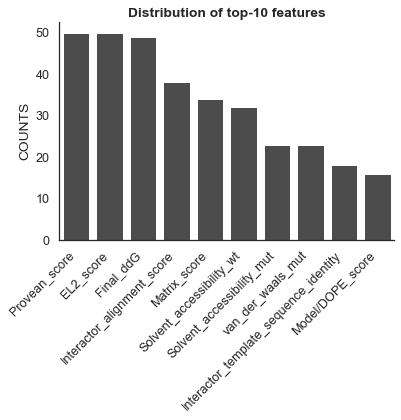

In [25]:
from helpers.helpers_predator.visualizers import visualize_distribution_top_n_features

visualize_distribution_top_n_features(predator.shap_feature_selector, 10)

In [26]:
predator.shap_feature_selector.display_rankings(10, extract=True)

2021-09-07 16:49:36 | DEBUG    | helpers.helpers_predator.feature_selection | Displaying rankings ..
2021-09-07 16:49:36 | DEBUG    | helpers.helpers_predator.feature_selection | Extracting rankings ..
2021-09-07 16:49:36 | DEBUG    | helpers.helpers_predator.feature_selection | Rankings are extracted to file rankings_10.csv.


,0,1,2,3,4,5,6,7,8,9
0,Provean_score,EL2_score,Matrix_score,electrostatics_mut,Final_ddG,Interactor_alignment_score,Solvent_accessibility_mut,Model/DOPE_score,van_der_waals_mut,pcv_vdW_self_wt
1,Provean_score,EL2_score,Final_ddG,solvation_polar_wt,entropy_mainchain_wt,sidechain_hbond_mut,Solvent_accessibility_mut,Solvent_accessibility_wt,van_der_waals_mut,Model/DOPE_score
2,EL2_score,Final_ddG,Provean_score,Interface_contact_distance_mut,Interface_contact_distance_wt,entropy_sidechain_wt,Solvent_accessibility_mut,entropy_sidechain_mut,pcv_vdW_wt,Interactor_alignment_score
3,EL2_score,Provean_score,Final_ddG,Interface_contact_distance_mut,entropy_sidechain_mut,Interactor_template_sequence_identity,van_der_waals_mut,Interface_contact_distance_wt,sidechain_hbond_wt,Model/DOPE_score
4,EL2_score,Provean_score,Final_ddG,sidechain_hbond_mut,Solvent_accessibility_wt,Matrix_score,entropy_sidechain_mut,entropy_sidechain_wt,sidechain_hbond_wt,Interactor_template_sequence_identity


In [27]:
predator.shap_feature_selector.n_features_to_aggregated_features

{5: ['EL2_score',
  'Provean_score',
  'Final_ddG',
  'Matrix_score',
  'Interactor_alignment_score'],
 10: ['Provean_score',
  'EL2_score',
  'Final_ddG',
  'Interactor_alignment_score',
  'Matrix_score',
  'Solvent_accessibility_wt',
  'Solvent_accessibility_mut',
  'van_der_waals_mut',
  'Interactor_template_sequence_identity',
  'Model/DOPE_score'],
 20: ['Provean_score',
  'EL2_score',
  'Final_ddG',
  'Interactor_alignment_score',
  'van_der_waals_mut',
  'Matrix_score',
  'Solvent_accessibility_wt',
  'Solvent_accessibility_mut',
  'Interactor_template_sequence_identity',
  'Model/DOPE_score',
  'entropy_sidechain_mut',
  'electrostatics_mut',
  'ProteinSolver_score',
  'ProtBert_score',
  'solvation_polar_wt',
  'entropy_mainchain_wt',
  'solvation_polar_mut',
  'entropy_sidechain_wt',
  'pcv_vdW_self_wt',
  'Interface_contact_distance_mut'],
 30: ['Provean_score',
  'EL2_score',
  'Final_ddG',
  'Interactor_alignment_score',
  'van_der_waals_mut',
  'Solvent_accessibility_wt',

In [28]:
predator.shap_feature_selector.n_features_to_aggregated_features[10]

['Provean_score',
 'EL2_score',
 'Final_ddG',
 'Interactor_alignment_score',
 'Matrix_score',
 'Solvent_accessibility_wt',
 'Solvent_accessibility_mut',
 'van_der_waals_mut',
 'Interactor_template_sequence_identity',
 'Model/DOPE_score']

## Evaluation Metrics

In [29]:
from helpers.helpers_predator.evaluation import evaluate_metrics

In [30]:
predator.initialize_evaluation_metrics()

2021-09-07 16:49:37 | INFO     | helpers.helpers_predator.evaluation | Initializing EvaluationMetrics..
2021-09-07 16:49:37 | INFO     | helpers.helpers_predator.evaluation | Initialize_benchmark_dataframes ..


In [39]:
predator.eval_metrics.run_eval_metrics(n_repeats=5, n_jobs=4, verbose=True)
# todo
# predator.run_evaluation_metrics(n_repeats=5, n_jobs=4, verbose=True)

2021-09-07 15:35:38 | INFO     | helpers.helpers_predator.evaluation | Running evaluation metrics ..


  0%|          | 0/50 [00:00<?, ?it/s]


EVALUATION METRIC: F1
------------------------------------
X_train_exp_0_provean       : 0.5025


KeyboardInterrupt: 

In [32]:
predator.eval_metrics.scoring_metrics_data

ValueError: Could not interpret input 'METRIC'

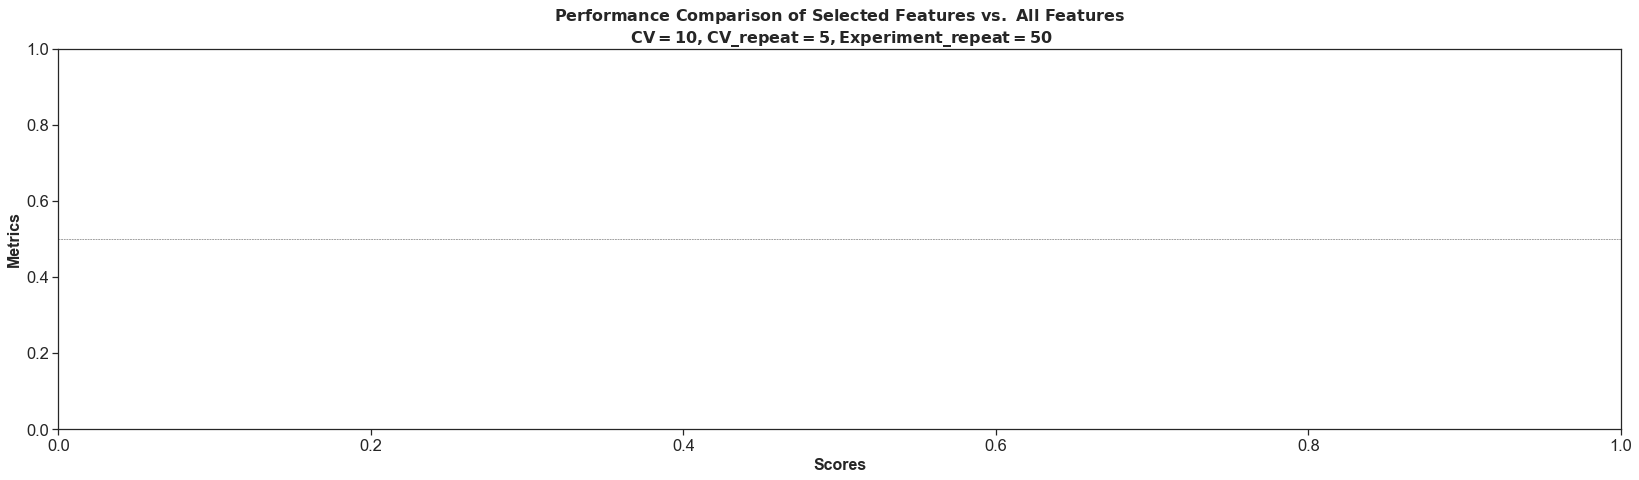

In [33]:
predator.eval_metrics.plot_performance_comparison_results()

## Fine Tuning

Fine Tuning on 80% of data (training *set*)

In [31]:
determined_feature_set = "shap_10"
predator.set_determined_feature_set(determined_feature_set)

2021-09-07 16:49:37 | DEBUG    | Predator | Setting determined feature set to `shap_10`.
2021-09-07 16:49:37 | DEBUG    | Predator | Setting determined features to 
['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interactor_template_sequence_identity', 'Model/DOPE_score'].


In [32]:
predator.init_fine_tuner(
    n_iter=1,
    n_repeats_cv=1,
    n_jobs=4,
    verbose=0,
)

In [33]:
predator.run_search("randomized")

2021-09-07 16:49:37 | DEBUG    | helpers.helpers_predator.fine_tuning | Running randomized search for each experiment ..
2021-09-07 16:49:37 | DEBUG    | helpers.helpers_predator.fine_tuning | PARAM_GRID: {'max_depth': [2, 5, 10], 'n_estimators': [10, 25, 50, 75, 100, 200, 400], 'min_samples_split': [2, 5], 'max_features': ['auto', 'sqrt', None], 'class_weight': ['balanced', None]}


  0%|          | 0/50 [00:00<?, ?it/s]

In [34]:
predator.fine_tuner.classifiers_attributes_data.head()

,best_params_,best_estimator_,best_score_
EXP_1,"{'n_estimators': 50, 'min_samples_split': 5, '...","(DecisionTreeClassifier(max_depth=2, min_sampl...",0.677083
EXP_2,"{'n_estimators': 10, 'min_samples_split': 2, '...","(DecisionTreeClassifier(max_depth=5, max_featu...",0.665694
EXP_3,"{'n_estimators': 25, 'min_samples_split': 5, '...","(DecisionTreeClassifier(max_depth=10, max_feat...",0.704028
EXP_4,"{'n_estimators': 75, 'min_samples_split': 5, '...","(DecisionTreeClassifier(max_depth=10, min_samp...",0.631111
EXP_5,"{'n_estimators': 25, 'min_samples_split': 2, '...","(DecisionTreeClassifier(max_depth=10, max_feat...",0.688472


In [35]:
predator.fine_tuner.best_estimators[:5]

[RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=None,
                        min_samples_split=5, n_estimators=50, random_state=1),
 RandomForestClassifier(max_depth=5, n_estimators=10, random_state=2),
 RandomForestClassifier(class_weight='balanced', max_depth=10,
                        max_features='sqrt', min_samples_split=5,
                        n_estimators=25, random_state=3),
 RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=None,
                        min_samples_split=5, n_estimators=75, random_state=4),
 RandomForestClassifier(class_weight='balanced', max_depth=10,
                        max_features='sqrt', n_estimators=25, random_state=5)]

In [36]:
len(predator.tuned_models)

50

In [37]:
predator.tuned_models[:5]

[RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=None,
                        min_samples_split=5, n_estimators=50, random_state=1),
 RandomForestClassifier(max_depth=5, n_estimators=10, random_state=2),
 RandomForestClassifier(class_weight='balanced', max_depth=10,
                        max_features='sqrt', min_samples_split=5,
                        n_estimators=25, random_state=3),
 RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=None,
                        min_samples_split=5, n_estimators=75, random_state=4),
 RandomForestClassifier(class_weight='balanced', max_depth=10,
                        max_features='sqrt', n_estimators=25, random_state=5)]

In [38]:
predator.fine_tuner.best_estimators[:5] == predator.tuned_models[:5]

True

In [39]:
predator.default_models[0]

RandomForestClassifier(random_state=42)

In [40]:
len(predator.tuned_models)

50

In [41]:
predator.tuned_models[0]

RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=None,
                       min_samples_split=5, n_estimators=50, random_state=1)

In [42]:
predator.tuned_models[1]

RandomForestClassifier(max_depth=5, n_estimators=10, random_state=2)

## Performance of Tuned Models on Validation Data

For each experiment, the **hyper-tuned** models are fitted with 80% of training data and predictions are made for the remaining 20%. Then performance is evaluated comparing predictions with groundtruth labels.

In [43]:
predator.run_evaluate_valid(models_type='tuned')

2021-09-07 16:50:47 | DEBUG    | helpers.helpers_predator.evaluation | Training on train set and measuring performance by predicting on validation set.
2021-09-07 16:50:47 | DEBUG    | helpers.helpers_predator.evaluation | Evaluating with tuned models.
2021-09-07 16:50:47 | DEBUG    | helpers.helpers_predator.evaluation | Determined features: 
['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interactor_template_sequence_identity', 'Model/DOPE_score']


  0%|          | 0/50 [00:00<?, ?it/s]

-------- EXPERIMENT:  1 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Accuracy score		: 0.7576
Balanced accuracy score : 0.7024
-------- EXPERIMENT:  2 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Accuracy score		: 0.6970
Balanced accuracy score : 0.6726
-------- EXPERIMENT:  3 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Accuracy score		: 0.7576
Balanced accuracy score : 0.7202
-------- EXPERIMENT:  4 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Accuracy score		: 0.8788
Balanced accuracy score : 0.8333
-------- EXPERIMENT:  5 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Accuracy score		: 0.7879
Balanced accuracy score : 0.7262
-------- EXPERIMENT:  6 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.sh

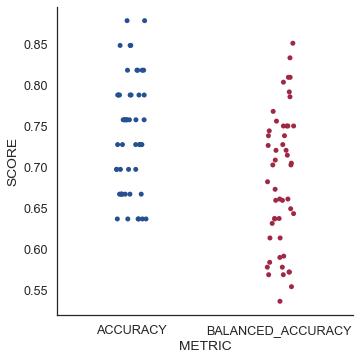

In [44]:
visualize_accuracy_metrics(
    predator.eval_valid.scores["finalized_scoring"]["acc_scores"], 
    predator.eval_valid.scores["finalized_scoring"]["balan_acc_scores"],
    kind='strip'
)

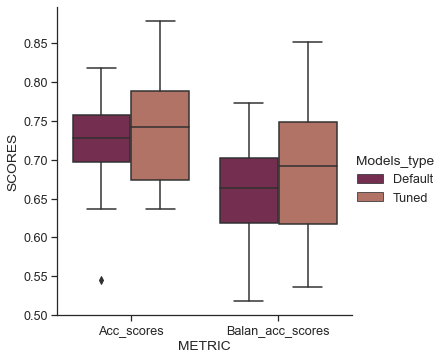

In [45]:
predator.eval_valid.comparison_default_vs_tuned(kind='box')

In [46]:
predator.eval_valid.comparison_data

Models_type,Default,Tuned
Acc_scores,0.728485,0.740606
Balan_acc_scores,0.663214,0.683885


## Fit Finalized Models

For each experiment, the **hyper-tuned** models are fitted with **all of training** data. These models then will be used to make prediction on TCGA Cancer Datasets.

In [47]:
predator.fit_finalized_models()

2021-09-07 16:51:00 | DEBUG    | Predator | Fitting finalized models with all training data ..


  0%|          | 0/50 [00:00<?, ?it/s]

## Prediction TCGA on Cancer Datasets

In [48]:
predator.initialize_target_data_materials()

2021-09-07 16:51:12 | DEBUG    | helpers.helpers_predator.data_materials | Initializing target data materials ..
2021-09-07 16:51:12 | DEBUG    | helpers.helpers_predator.data_materials | Determined features: ['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interactor_template_sequence_identity', 'Model/DOPE_score']
2021-09-07 16:51:12 | DEBUG    | helpers.helpers_predator.data_materials | Declaring Xs_brca data materials  ..


### Voting mode: `hard`

In [49]:
predator.predict(voting='hard')

2021-09-07 16:51:12 | DEBUG    | Predator | Predicting on cancer datasets ..
2021-09-07 16:51:12 | DEBUG    | helpers.helpers_predator.models | Initializing EnsambledVotingClassifier.
2021-09-07 16:51:12 | DEBUG    | helpers.helpers_predator.models | Voting mode: hard
2021-09-07 16:51:12 | DEBUG    | helpers.helpers_predator.predictions | Initializing: PredictionsHard
2021-09-07 16:51:12 | DEBUG    | Predator | Predicting on brca cohort ..
2021-09-07 16:51:12 | DEBUG    | helpers.helpers_predator.models | Current estimator: RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=None,
                       min_samples_split=5, n_estimators=50, random_state=1)
2021-09-07 16:51:12 | DEBUG    | helpers.helpers_predator.models | X shape: (4452, 10)
2021-09-07 16:51:12 | DEBUG    | helpers.helpers_predator.models | Current estimator: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=2)
2021-09-07 16:51:12 | DEBUG    | helpers.helpers_predator.models | X sh

In [50]:
predator.predictions.keys()

dict_keys(['brca'])

In [51]:
# Predictions for first 10 experiment.
predator.predictions["brca"][:3]

[array([1, 1, 1, ..., 1, 1, 1], dtype=int64),
 array([0, 0, 0, ..., 1, 1, 0], dtype=int64),
 array([0, 0, 0, ..., 1, 1, 1], dtype=int64)]

2021-09-07 16:51:15 | DEBUG    | helpers.helpers_predator.predictions | Initializing value counts ..


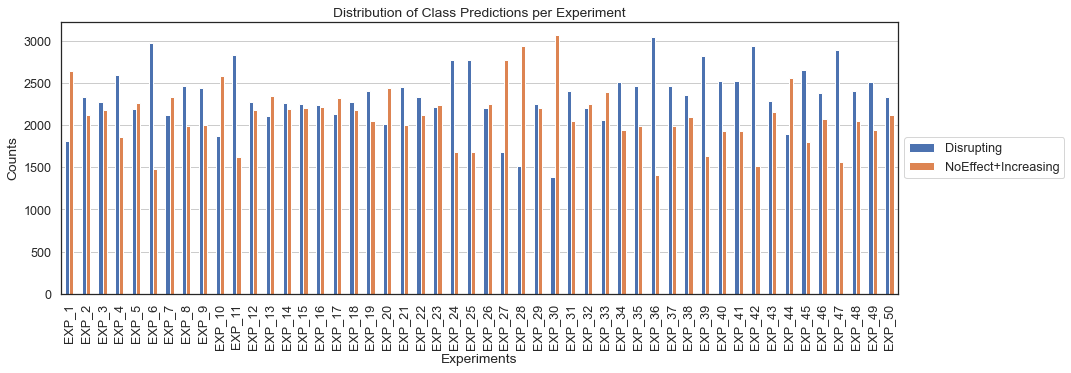

In [52]:
predator.predictions.plot_predictions_distributions("brca")

#### Predictions Post Processing

Post processing of predictions involves following steps:

##### 1. Merging Predictions with SNV Data

The prediction column is merged with SNV data for each experiment.

$\text{For each experiment } n: $

$$
  \textit{(Prediction Merged Data)}_n = \underbrace{[\textit{Predictions}_n]}_\text{0, 1 or "NoVote"} + 
      \underbrace{[\textit{Protein }] [\textit{Mutation }] [\textit{Interactor }]}_\text{Cancer Data Triplets} + \underbrace{[\textit{Features }] }_\text{Elaspic}
$$


##### 2. Convert to 1-isomer: `Interactor_UniProt_ID`

$\textit{Interactor_UniProt_ID}$ column contains isomer proteins. Here, we convert them into primary isoform representation (i.e. without dashes).

| Interactor_UniProt_ID |
--------------
| P38936     |
| P16473     |
| P16473-2   |
| P19793     |

##### 3. Dropping Invalid Predictions

Entries which predicted as both `Decreasing` and `Increasing+NoEff` are dropped.

Due to having different features for the same $\textit{(protein, mutation, interactor)}$ triplet from ELASPIC, the triplet $\textit{(protein, mutation, interactor)}$ may be classified both 0 and 1. We drop such instances.

In [53]:
predator.predictions_post_process()

2021-09-07 16:51:17 | DEBUG    | helpers.helpers_predator.predictions | PredictionsHard
2021-09-07 16:51:17 | DEBUG    | helpers.helpers_predator.predictions | Post processing predictions for cohort brca ..
2021-09-07 16:51:17 | DEBUG    | helpers.helpers_predator.predictions | Merging predictions with brca cancer dataset ..


  0%|          | 0/50 [00:00<?, ?it/s]

2021-09-07 16:51:28 | DEBUG    | helpers.helpers_predator.predictions_utils | Removed entries first five rows (of 240): 
   PREDICTIONS PROTEIN MUTATION INTERACTOR
0            0  P42336   H1047R     O00459
1            1  P42336   H1047R     O00459
2            1  Q9UBN7    D567Y     Q96DB2
3            0  Q9UBN7    D567Y     Q96DB2
4            0  P29466    R374L     Q92851
2021-09-07 16:51:39 | DEBUG    | helpers.helpers_predator.predictions_utils | Removed entries first five rows (of 637): 
   PREDICTIONS PROTEIN MUTATION INTERACTOR
0            1  Q9UBN7    D567Y     Q96DB2
1            0  Q9UBN7    D567Y     Q96DB2
2            0  P04637    R280K     Q13625
3            1  P04637    R280K     Q13625
4            1  P04637    R280K     Q13625
2021-09-07 16:51:51 | DEBUG    | helpers.helpers_predator.predictions_utils | Removed entries first five rows (of 750): 
   PREDICTIONS PROTEIN MUTATION INTERACTOR
0            1  P42336   H1047R     P27986
1            0  P42336   H1047R    

In [54]:
predator.predictions.keys()

dict_keys(['brca', 'brca_predicted_datasets', 'brca_predicted_valid_datasets', 'brca_predicted_invalid_datasets', 'brca_finalized_prediction_dataframes'])

In [55]:
predator.predictions["brca_predicted_datasets"][0].head(3)

,Predictions,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,1,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,1,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,1,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224


In [56]:
predator.predictions["brca_predicted_datasets"][17].head(3)

,Predictions,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,0,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,0,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224


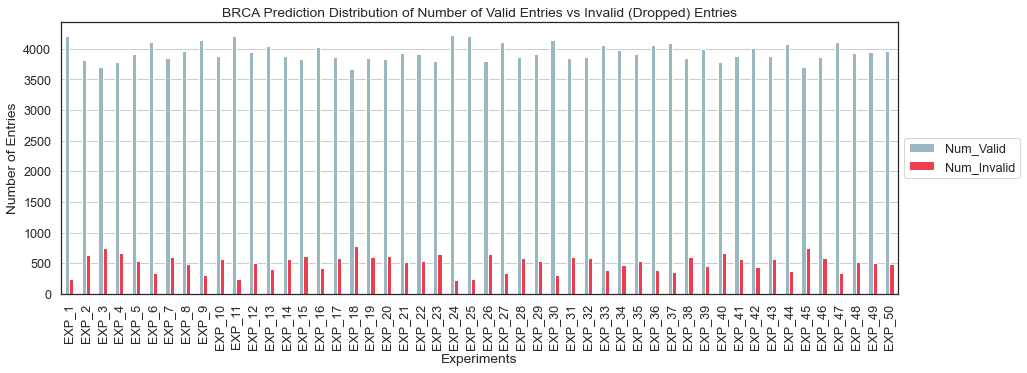

In [57]:
predator.predictions.plot_distribution_valid_vs_invalid("brca")

2021-09-07 17:00:29 | DEBUG    | helpers.helpers_predator.predictions | Plotting number of finalized predictions per experiment.
Note that following plot shows the unique (protein, mutation, interactor) triplets which had valid prediction.


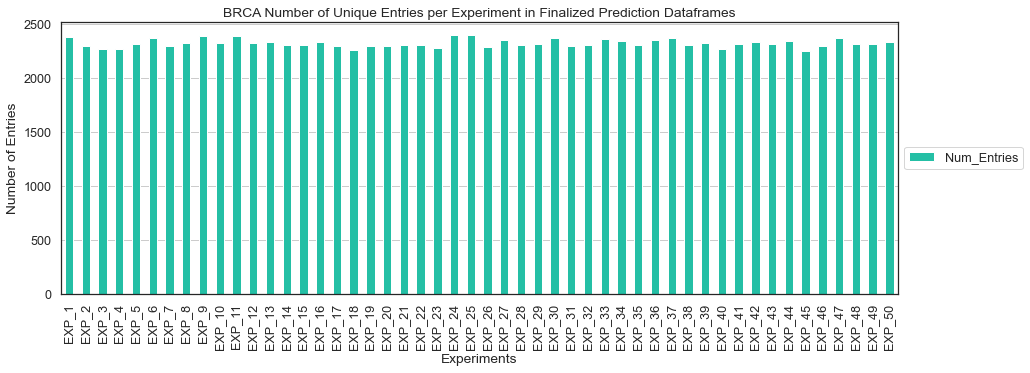

In [58]:
predator.predictions.plot_num_finalized_predictions("brca")

In [59]:
predator.prepare_ensemble_prediction_data()

2021-09-07 17:00:31 | DEBUG    | helpers.helpers_predator.predictions | PredictionsHard
2021-09-07 17:00:31 | DEBUG    | helpers.helpers_predator.predictions | Preparing ensemble prediction data for brca ..


  0%|          | 0/2448 [00:00<?, ?it/s]

2021-09-07 17:04:07 | DEBUG    | helpers.helpers_predator.predictions | Ensemble prediction data for brca is prepared.
2021-09-07 17:04:07 | DEBUG    | helpers.helpers_predator.predictions | Resulting prediction data is available for brca.
Accessible from predictions.['brca_prediction_results']


In [60]:
# Maybe in no_vote cases, we'll ignore and put which of class0 or class1 vote is more will be put (as we did in prob cases.)
predator.predictions["brca_ensemble_prediction_data"].head()

,UniProt_ID,Mutation,Interactor_UniProt_ID,Num_preds_0,Num_preds_1,Num_preds_NO_VOTE,VOTED_PREDICTION
0,Q9UKS6,R24H,Q9BY11,45,5,0,0
1,Q9UKS6,R24H,Q9UNF0,47,3,0,0
2,Q9UKS6,R24H,Q5TZC3,39,11,0,0
3,Q9UKS6,R24H,Q6FIA3,47,3,0,0
4,P42336,H1047R,Q13535,6,44,0,1


In [61]:
print(predator.data_materials["brca"].shape)
predator.data_materials["brca"].head()

(4452, 103)


,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,Domain_clan,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224
3,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,571.0,71.7108,71.2911,46.7150,46.6809,1491.81,704.155,2195.98,2.88254,3.23468
4,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224


In [62]:
print(predator.data_materials["Xs_brca"][0].shape)
predator.data_materials["Xs_brca"][0].head()

(4452, 10)


,Provean_score,EL2_score,Final_ddG,Interactor_alignment_score,Matrix_score,Solvent_accessibility_wt,Solvent_accessibility_mut,van_der_waals_mut,Interactor_template_sequence_identity,Model/DOPE_score
0,-4.726,1.761235,0.730056,0.936088,0.0,86.9245,74.8117,-64.1391,0.9857,-1.137780
1,-4.726,1.129695,0.795178,0.993160,0.0,68.1041,64.0505,-64.9898,0.9928,-0.929739
2,-4.726,1.270361,1.030540,0.993160,0.0,70.2800,55.9307,-64.8110,0.9928,-0.896799
3,-4.726,1.507389,0.324135,0.936088,0.0,85.6674,73.2438,-64.1094,0.9857,-1.158870
4,-4.726,1.270361,1.030540,0.993160,0.0,70.2800,55.9307,-64.8110,0.9928,-0.896799


In [63]:
predator.data_materials["Xs_brca"][0].iloc[[0]]

,Provean_score,EL2_score,Final_ddG,Interactor_alignment_score,Matrix_score,Solvent_accessibility_wt,Solvent_accessibility_mut,van_der_waals_mut,Interactor_template_sequence_identity,Model/DOPE_score
0,-4.726,1.761235,0.730056,0.936088,0.0,86.9245,74.8117,-64.1391,0.9857,-1.13778


In [64]:
# --- debug
preds = []
for exp, model in enumerate(predator.finalized_models):
    assert(list(model.classes_) == [0, 1])
    [pred] = model.predict(predator.data_materials['Xs_brca'][0].iloc[[0]])
    preds.append(pred)

from collections import Counter

c = Counter(preds)
c

Counter({1: 5, 0: 45})

In [65]:
# --- debug
preds_probs = []
for exp, model in enumerate(predator.finalized_models):
    assert(list(model.classes_) == [0, 1])
    [pred_prob] = model.predict_proba(predator.data_materials['Xs_brca'][0].iloc[[0]])
    preds_probs.append(pred_prob)

S = pd.Series(preds_probs)
S

0       [0.4564501141191841, 0.543549885880816]
1      [0.5916973251421781, 0.4083026748578219]
2      [0.5207589494598791, 0.4792410505401209]
3     [0.7404154242164316, 0.25958457578356847]
4                                    [0.6, 0.4]
5       [0.5904471864376047, 0.409552813562395]
6      [0.6981408649829702, 0.3018591350170297]
7     [0.6291836682566319, 0.37081633174336803]
8     [0.6454285068898696, 0.35457149311013036]
9     [0.5620568260955282, 0.43794317390447174]
10      [0.673572909083728, 0.3264270909162717]
11     [0.6032224640595658, 0.3967775359404343]
12    [0.6704202351271096, 0.32957976487289015]
13     [0.7747462267129355, 0.2252537732870646]
14    [0.5142522824319521, 0.48574771756804774]
15     [0.5128068146638127, 0.4871931853361873]
16     [0.6765292616519202, 0.3234707383480797]
17       [0.637311660407397, 0.362688339592603]
18      [0.6601482144670482, 0.339851785532952]
19                                 [0.48, 0.52]
20     [0.7404587994499591, 0.2595412005

2021-09-07 17:04:10 | WARNING  | helpers.helpers_predator.predictions | Index(['UniProt_ID', 'Mutation', 'Interactor_UniProt_ID', 'Num_preds_0',
       'Num_preds_1', 'Num_preds_NO_VOTE', 'VOTED_PREDICTION'],
      dtype='object')


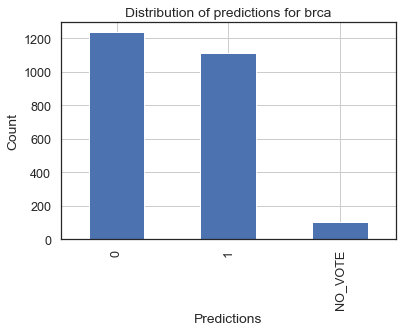

In [66]:
predator.predictions.plot_ensemble_prediction_distribution("brca")

In [67]:
brca_prediction_results_hard = predator.predictions["brca_prediction_results"]
brca_prediction_results_hard.head()

,UniProt_ID,Mutation,Interactor_UniProt_ID,PREDICTION
0,Q9UKS6,R24H,Q9BY11,0
1,Q9UKS6,R24H,Q9UNF0,0
2,Q9UKS6,R24H,Q5TZC3,0
3,Q9UKS6,R24H,Q6FIA3,0
4,P42336,H1047R,Q13535,1


In [69]:
brca_prediction_results_hard_no_votes_dropped = (
    brca_prediction_results_hard[brca_prediction_results_hard['PREDICTION'].isin([0, 1])]
)

2021-09-07 17:12:57 | DEBUG    | helpers.helpers_predator.displayers | Label counts:
Disrupting                1237
Increasing + No Effect    1111
Name: PREDICTION, dtype: int64


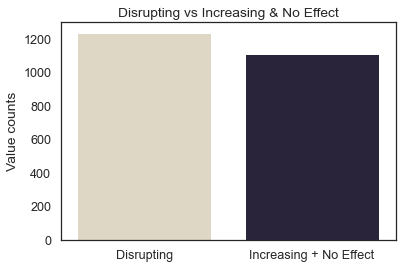

In [71]:
visualize_label_counts(brca_prediction_results_hard_no_votes_dropped, 'PREDICTION')

In [72]:
brca_ensemble_prediction_data_hard = predator.predictions["brca_ensemble_prediction_data"]

### Voting mode: `soft`

In [73]:
predator.initialize_target_data_materials()

2021-09-07 17:13:04 | DEBUG    | helpers.helpers_predator.data_materials | Initializing target data materials ..
2021-09-07 17:13:04 | DEBUG    | helpers.helpers_predator.data_materials | Determined features: ['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interactor_template_sequence_identity', 'Model/DOPE_score']
2021-09-07 17:13:04 | DEBUG    | helpers.helpers_predator.data_materials | Declaring Xs_brca data materials  ..


In [74]:
predator.predict(voting='soft')

2021-09-07 17:13:05 | DEBUG    | Predator | Predicting on cancer datasets ..
2021-09-07 17:13:05 | DEBUG    | helpers.helpers_predator.models | Initializing EnsambledVotingClassifier.
2021-09-07 17:13:05 | DEBUG    | helpers.helpers_predator.models | Voting mode: soft
2021-09-07 17:13:05 | DEBUG    | helpers.helpers_predator.predictions | Initializing: PredictionsSoft
2021-09-07 17:13:05 | DEBUG    | Predator | Predicting on brca cohort ..
2021-09-07 17:13:05 | DEBUG    | helpers.helpers_predator.models | Current estimator: RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=None,
                       min_samples_split=5, n_estimators=50, random_state=1)
2021-09-07 17:13:05 | DEBUG    | helpers.helpers_predator.models | X shape: (4452, 10)
2021-09-07 17:13:05 | DEBUG    | helpers.helpers_predator.models | Current estimator: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=2)
2021-09-07 17:13:05 | DEBUG    | helpers.helpers_predator.models | X sh

In [75]:
predator.predictions.keys()

dict_keys(['brca_prob'])

In [76]:
# Predictions for first 10 experiment.
predator.predictions["brca_prob"][:3]

[array([[0.45645011, 0.54354989],
        [0.49007113, 0.50992887],
        [0.49007113, 0.50992887],
        ...,
        [0.40681387, 0.59318613],
        [0.39057652, 0.60942348],
        [0.37586509, 0.62413491]]),
 array([[0.59169733, 0.40830267],
        [0.65245731, 0.34754269],
        [0.80568143, 0.19431857],
        ...,
        [0.29203034, 0.70796966],
        [0.46314916, 0.53685084],
        [0.62164343, 0.37835657]]),
 array([[0.52075895, 0.47924105],
        [0.62535211, 0.37464789],
        [0.73573591, 0.26426409],
        ...,
        [0.26508479, 0.73491521],
        [0.46901171, 0.53098829],
        [0.2723316 , 0.7276684 ]])]

#### Predictions Post Processing

Post processing of predictions involves following steps:

##### 1. Merging Predictions with SNV Data

The prediction column is merged with SNV data for each experiment.

$\text{For each experiment } n: $

$$
  \textit{(Prediction Merged Data)}_n = \underbrace{[\textit{Predictions}_n]}_\text{Probs Percentages} + 
      \underbrace{[\textit{Protein }] [\textit{Mutation }] [\textit{Interactor }]}_\text{Cancer Data Triplets} + \underbrace{[\textit{Features }] }_\text{Elaspic}
$$


##### 2. Convert to 1-isomer: `Interactor_UniProt_ID`

$\textit{Interactor_UniProt_ID}$ column contains isomer proteins. Here, we convert them into primary isoform representation (i.e. without dashes).

| Interactor_UniProt_ID |
--------------
| P38936     |
| P16473     |
| P16473-2   |
| P19793     |

##### 3. Dropping Invalid Predictions

--- todo  add documentation

In [77]:
predator.predictions_post_process()

2021-09-07 17:13:08 | DEBUG    | helpers.helpers_predator.predictions | PredictionsSoft
2021-09-07 17:13:08 | DEBUG    | helpers.helpers_predator.predictions | Post processing predictions for cohort brca ..
2021-09-07 17:13:08 | DEBUG    | helpers.helpers_predator.predictions | PredictionsSoft
2021-09-07 17:13:08 | DEBUG    | helpers.helpers_predator.predictions | Merging predictions with brca cancer dataset ..


  0%|          | 0/50 [00:00<?, ?it/s]

2021-09-07 17:13:20 | DEBUG    | helpers.helpers_predator.predictions_utils | Removed entries first five rows (of 240): 
   PREDICTIONS PROTEIN MUTATION INTERACTOR
0     0.490482  P42336   H1047R     O00459
1     0.538929  P42336   H1047R     O00459
2     0.522040  Q9UBN7    D567Y     Q96DB2
3     0.392023  Q9UBN7    D567Y     Q96DB2
4     0.488818  P29466    R374L     Q92851
2021-09-07 17:13:36 | DEBUG    | helpers.helpers_predator.predictions_utils | Removed entries first five rows (of 632): 
   PREDICTIONS PROTEIN MUTATION INTERACTOR
0     0.836205  Q9UBN7    D567Y     Q96DB2
1     0.429703  Q9UBN7    D567Y     Q96DB2
2     0.253626  P04637    R280K     Q13625
3     0.701587  P04637    R280K     Q13625
4     0.701587  P04637    R280K     Q13625
2021-09-07 17:13:47 | DEBUG    | helpers.helpers_predator.predictions_utils | Removed entries first five rows (of 750): 
   PREDICTIONS PROTEIN MUTATION INTERACTOR
0     0.573184  P42336   H1047R     P27986
1     0.477561  P42336   H1047R    

In [78]:
predator.predictions.keys()

dict_keys(['brca_prob', 'brca_predicted_probs_datasets', 'brca_predicted_valid_datasets', 'brca_predicted_invalid_datasets', 'brca_finalized_prediction_dataframes'])

In [79]:
predator.predictions["brca_predicted_probs_datasets"][0].head(3)

,Predictions,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0.543550,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,0.509929,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,0.509929,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224


In [80]:
predator.predictions["brca_predicted_probs_datasets"][17].head(3)

,Predictions,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0.362688,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,0.421603,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,0.158736,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224


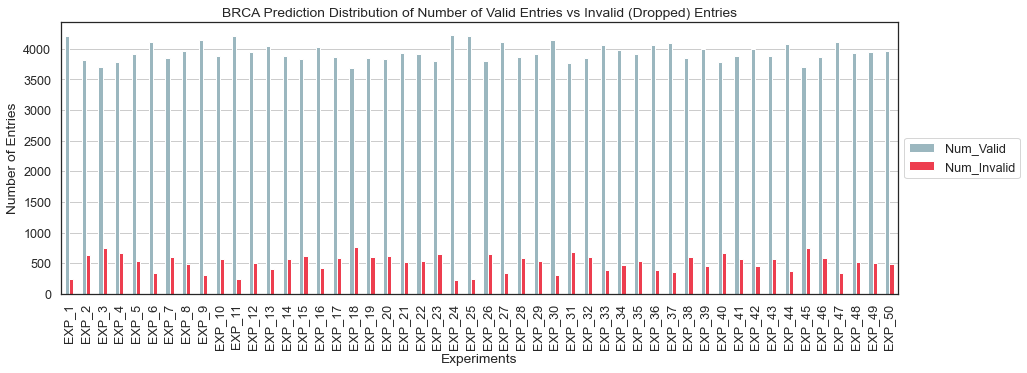

In [81]:
predator.predictions.plot_distribution_valid_vs_invalid("brca")

2021-09-07 17:23:24 | DEBUG    | helpers.helpers_predator.predictions | Plotting number of finalized predictions per experiment.
Note that following plot shows the unique (protein, mutation, interactor) triplets which had valid prediction.


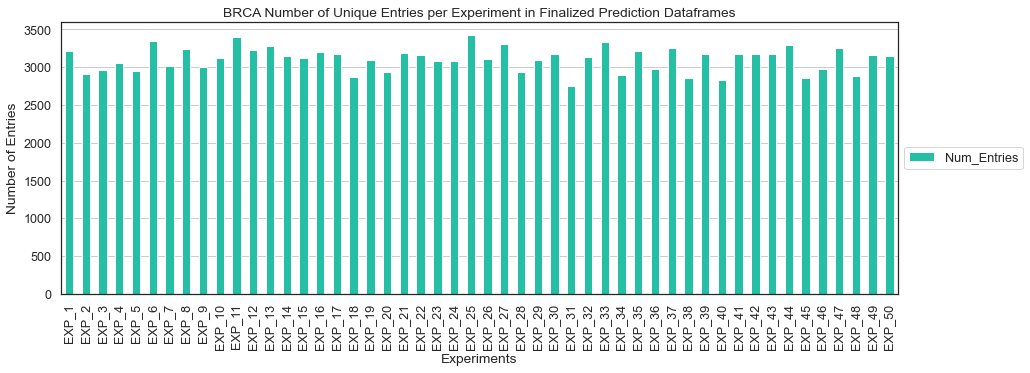

In [82]:
# ????, why goes up to 3500?
predator.predictions.plot_num_finalized_predictions("brca")

In [83]:
predator.predictions['brca_finalized_prediction_dataframes'][0].head()

,Predictions,UniProt_ID,Mutation,Interactor_UniProt_ID
0,0.543550,Q9UKS6,R24H,Q9BY11
1,0.509929,Q9UKS6,R24H,Q9UNF0
3,0.562368,Q9UKS6,R24H,Q5TZC3
4,0.509929,Q9UKS6,R24H,Q6FIA3
5,0.747479,P42336,H1047R,Q13535


In [84]:
predator.prepare_ensemble_prediction_data()

2021-09-07 17:23:26 | DEBUG    | helpers.helpers_predator.predictions | PredictionsSoft
2021-09-07 17:23:26 | DEBUG    | helpers.helpers_predator.predictions | Preparing ensemble prediction data for brca ..


  0%|          | 0/50 [00:00<?, ?it/s]

2021-09-07 17:27:19 | DEBUG    | helpers.helpers_predator.predictions | Prediction probabilities data for brca is prepared.Accessible from `brca_predictions_prob_data`.
2021-09-07 17:27:19 | DEBUG    | helpers.helpers_predator.predictions | Ensemble prediction data for brca is prepared.Accessible from `brca_ensemble_prediction_data`.
2021-09-07 17:27:19 | DEBUG    | helpers.helpers_predator.predictions | Resulting prediction data is available for brca.
Accessible from predictions.['brca_prediction_results']


In [85]:
predator.predictions['brca_predictions_prob_data'].head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,PROB_1s_AVG,VOTED_PREDICTION
0,0.54355,0.408303,0.479241,0.259585,0.4,0.409553,0.301859,0.370816,0.354571,0.437943,...,0.327277,0.557915,0.350417,0.485333,0.336854,0.390205,0.269865,0.337405,0.387738,0
1,0.509929,0.270931,0.319456,0.225353,0.42,0.382262,0.372803,0.338909,0.332764,0.443708,...,0.262872,0.537989,0.35832,0.434037,0.325209,0.360443,0.250105,0.428868,0.351211,0
2,0.562368,0.356636,0.449606,0.303085,0.4,0.413258,0.294829,0.426841,0.354571,0.446066,...,0.4459,0.575278,0.406667,0.597421,0.336854,0.524331,0.28072,0.43832,0.427009,0
3,0.509929,0.194319,0.264264,0.177347,0.36,0.37044,0.324858,0.270716,0.283141,0.429073,...,0.238679,0.521738,0.364557,0.455422,0.320981,0.360443,0.201772,0.375286,0.320551,0
4,0.747479,0.838542,0.723308,0.601914,0.52,0.555234,0.659,0.675872,0.486902,0.632712,...,0.669572,0.718597,0.908333,0.769048,0.519278,0.444215,0.759027,0.64993,0.621074,1


In [86]:
brca_prediction_results_soft = predator.predictions['brca_prediction_results']
brca_prediction_results_soft.head()

,UniProt_ID,Mutation,Interactor_UniProt_ID,PREDICTION
0,Q9UKS6,R24H,Q9BY11,0
1,Q9UKS6,R24H,Q9UNF0,0
2,Q9UKS6,R24H,Q5TZC3,0
3,Q9UKS6,R24H,Q6FIA3,0
4,P42336,H1047R,Q13535,1


2021-09-07 17:50:28 | DEBUG    | helpers.helpers_predator.displayers | Label counts:
Disrupting                1280
Increasing + No Effect    1168
Name: PREDICTION, dtype: int64


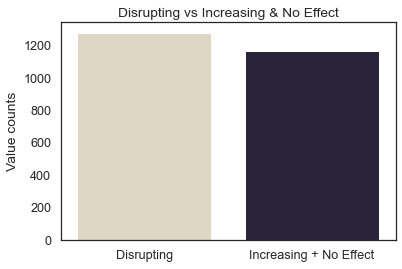

In [88]:
visualize_label_counts(brca_prediction_results_soft, 'PREDICTION')

2021-09-07 17:50:29 | DEBUG    | helpers.helpers_predator.displayers | Label counts:
Disrupting                1237
Increasing + No Effect    1111
Name: PREDICTION, dtype: int64


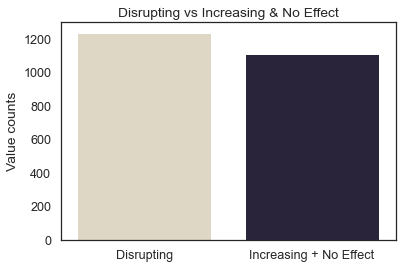

In [89]:
visualize_label_counts(brca_prediction_results_hard_no_votes_dropped, 'PREDICTION')

# debug: 
34	O14980	E571K	O95149	NO_VOTE

predator.predictions['brca_predictions_prob_data'].iloc[34].value_counts() → there isnt any "NO_VOTE"

In [97]:
brca_prediction_results_hard[brca_prediction_results_hard['PREDICTION'] == 'NO_VOTE'].sample()

,UniProt_ID,Mutation,Interactor_UniProt_ID,PREDICTION
1535,P01112,G12D,Q13905,NO_VOTE


In [98]:
def get_stats(vals):
    num_class_0 = len([val for val in vals if type(val) is not str and val < 0.5])
    num_class_1 = len([val for val in vals if type(val) is not str and val >= 0.5])
    num_no_vote = len([val for val in vals if val == "NO_VOTE"])
    print(f"num_class_0: {num_class_0}\nnum_class_1: {num_class_1}\nnum_no_vote: {num_no_vote}\nTotal      : {num_class_0+num_class_1+num_no_vote}")

In [99]:
# ????
get_stats(predator.predictions['brca_predictions_prob_data'].drop(['PROB_1s_AVG', 'VOTED_PREDICTION'], axis='columns').iloc[34].values)

num_class_0: 24
num_class_1: 26
num_no_vote: 0
Total      : 50


In [100]:
brca_prediction_results_hard.iloc[[34]]

,UniProt_ID,Mutation,Interactor_UniProt_ID,PREDICTION
34,O14980,E571K,O95149,NO_VOTE


In [101]:
predator.predictions['brca_prediction_results'].iloc[[34]]

,UniProt_ID,Mutation,Interactor_UniProt_ID,PREDICTION
34,O14980,E571K,O95149,0


In [102]:
brca_ensemble_prediction_data_soft = predator.predictions["brca_ensemble_prediction_data"]

In [103]:
brca_ensemble_prediction_data_hard.head()

,UniProt_ID,Mutation,Interactor_UniProt_ID,Num_preds_0,Num_preds_1,Num_preds_NO_VOTE,VOTED_PREDICTION
0,Q9UKS6,R24H,Q9BY11,45,5,0,0
1,Q9UKS6,R24H,Q9UNF0,47,3,0,0
2,Q9UKS6,R24H,Q5TZC3,39,11,0,0
3,Q9UKS6,R24H,Q6FIA3,47,3,0,0
4,P42336,H1047R,Q13535,6,44,0,1


In [104]:
brca_ensemble_prediction_data_soft.head()

,UniProt_ID,Mutation,Interactor_UniProt_ID,0,1,2,3,4,5,6,...,41,42,43,44,45,46,47,48,49,VOTED_PREDICTION
0,Q9UKS6,R24H,Q9BY11,0.54355,0.408303,0.479241,0.259585,0.4,0.409553,0.301859,...,0.34,0.327277,0.557915,0.350417,0.485333,0.336854,0.390205,0.269865,0.337405,0
1,Q9UKS6,R24H,Q9UNF0,0.509929,0.270931,0.319456,0.225353,0.42,0.382262,0.372803,...,0.415,0.262872,0.537989,0.35832,0.434037,0.325209,0.360443,0.250105,0.428868,0
2,Q9UKS6,R24H,Q5TZC3,0.562368,0.356636,0.449606,0.303085,0.4,0.413258,0.294829,...,0.43,0.4459,0.575278,0.406667,0.597421,0.336854,0.524331,0.28072,0.43832,0
3,Q9UKS6,R24H,Q6FIA3,0.509929,0.194319,0.264264,0.177347,0.36,0.37044,0.324858,...,0.36,0.238679,0.521738,0.364557,0.455422,0.320981,0.360443,0.201772,0.375286,0
4,P42336,H1047R,Q13535,0.747479,0.838542,0.723308,0.601914,0.52,0.555234,0.659,...,0.67,0.669572,0.718597,0.908333,0.769048,0.519278,0.444215,0.759027,0.64993,1


## Exporting Predictions

In [105]:
brca_prediction_results_soft.head()

,UniProt_ID,Mutation,Interactor_UniProt_ID,PREDICTION
0,Q9UKS6,R24H,Q9BY11,0
1,Q9UKS6,R24H,Q9UNF0,0
2,Q9UKS6,R24H,Q5TZC3,0
3,Q9UKS6,R24H,Q6FIA3,0
4,P42336,H1047R,Q13535,1


In [115]:
from helpers.helpers_predator.common import export_data

In [128]:
DATA_FOLDER_PATH = "../data/predictions_datasets/"

In [130]:
export_data(
    folder_path=DATA_FOLDER_PATH,
    data=brca_prediction_results_soft,
    file_name="predictions_uh",
    file_extension='csv',
    overwrite=False,
)

2021-09-07 18:21:00 | DEBUG    | helpers.helpers_predator.common | Exporting data predictions_uh at location ../data/predictions_datasets/ ..
2021-09-07 18:21:00 | INFO     | helpers.helpers_predator.common | ../data/predictions_datasets/predictions_uh_2021-09-07.csv is exported successfully.


**Later**

Maybe as number of experiment goes to positive infinity, the class 0 and class 1 distribution gets equals. 

After looking at ROC Curves, we can decide to assign class 0 if we are very confident, i.e. prediction probability above some
threshold, rather than 0.50